# 1. import des librairies

Elle consiste à importer les librairies pour utiliser Python et faire les calculs

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt # librairie pour les figures
import pandas as pd # pour lire les tableaux
import numpy as np # librairie de calcul numérique
import rampy as rp # librairie spétialisée pour le traitement des spectres
from rampy import maps # sous-librairie pour les cartographies
from scipy.optimize import curve_fit # fonction pour le fitting des profils de diffusion
# pour gérer les incertitudes et leur propagation automatique
import uncertainties
from uncertainties import unumpy

# 2. Import des données

L'import de carte se fait en utilisant la fonction map de rampy.maps. rampy gère pour le moment deux marques de spectromètres : renishaw et horiba.

Ceci créé un objet python avec des attributs, contenant les spectres mais aussi leurs méthodes de traitement... Un peu déroutant au début mais très puissant quand on réalise que tout peut être effectué en manipulant cet objet.

In [2]:
my_map = rp.maps.map('./data/ZA0214.txt', spectrometer_type="horiba")

# ici l'objet est donc 'my_map'

## 2.1 Figure

On représente ci-dessous tous les spectres.

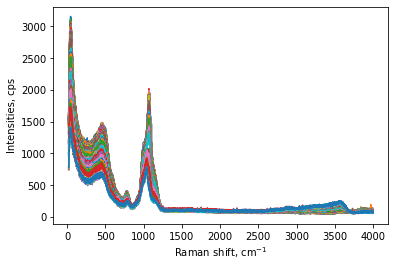

In [3]:
# déclaration d'une nouvelle figure
plt.figure()

# faire la figure : plot(x, y)
plt.plot(my_map.w, my_map.I)

# les labels
plt.xlabel('Raman shift, cm$^{-1}$')
plt.ylabel("Intensities, cps")

# pour être sûr.e que la figure s'affiche
plt.show()

# 3. Enlever le fond spectral et normaliser le spectre

On remarque que les spectres sont affectés par un fond spectral non-linéaire. Plusieurs possibilités sont disponibles pour l'enlever, voir https://github.com/charlesll/rampy/blob/master/examples/baseline_fit.ipynb

Ici, on va soustraire une fonction polynomial de deuxième ordre qui va être contrainte sur les zones 1400-2600, et 3800-4050 cm$^{-1}$. On déclare donc ces zones dans bir, et on appelle la méthode background de notre carte.

## 3.1 Fond spectral

In [4]:
# déclaration des zones d'intérêt
bir = np.array([[1400,2600],[3800,4050]])
# on appelle la méthode background
my_map.background(bir, "poly", polynomial_order=2)

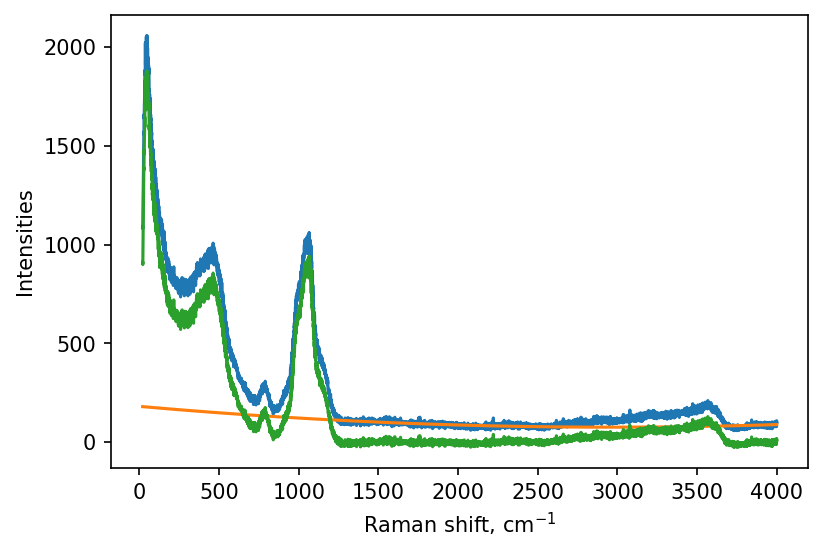

In [5]:
# et on fait une nouvelle figure en montrant le spectre 50 (modifier la variable idx_sp_to_plot pour en voir d'autre)
plt.figure(dpi=150)

idx_sp_to_plot = 70
# we plot the original signal
plt.plot(my_map.w, my_map.I[:,idx_sp_to_plot])

# we plot the background
plt.plot(my_map.w, my_map.I_background[:,idx_sp_to_plot])

# we plot the corrected spectra
plt.plot(my_map.w, my_map.I_corrected[:,idx_sp_to_plot])

plt.xlabel('Raman shift, cm$^{-1}$')
plt.ylabel("Intensities")
plt.show()

## 3.2 Normaliser les spectres

On peut les normaliser selon leur aire total, ou l'intensité maximale... Ici on choisi de le faire selon l'aire.

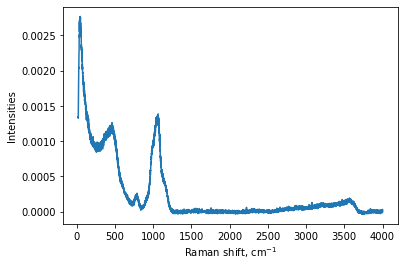

In [6]:
my_map.normalise(my_map.I_corrected, method = "area")

plt.figure()

# we plot the normalised spectra
plt.plot(my_map.w, my_map.I_normalised[:,idx_sp_to_plot])

plt.xlabel('Raman shift, cm$^{-1}$')
plt.ylabel("Intensities")
plt.show()

# 4. L'analyse à proprement parler.

Maintenant que nos spectres sont "pré-traités", on peut les sauver ou continuer l'analyse. D'après les figures déjà effectuées, on voit des variations dans les signaux vers 1000 cm$^{-1}$ et 3600 cm$^{-1}$. On peut donc faire différent calculs:
- intensité maximum > my_map.intensity(signal à traiter, region à considérer)
- rapport d'intensité avec un autre pic > my_map.intensity_ratio(signaux à traiter, regions à considérer)
- aire sous le pic > my_map.area(signal à traiter, region à considérer)
- ou rapport d'aire avec un autre pic > my_map.area_ratio(signaux à traiter, regions à considérer)

## 4.1 Analyse de l'aire d'un pic

Ici, nous choisissons simplement de calculer l'aire sous le pic vers 3500 cm$^{-1}$. Ce pic est attribué à des vibrations d'étirement O-H, et indique donc de l'eau dissoute dans le verre. On pourra par exemple l'utiliser pour calculer la teneur en eau du verre (c.f. Le Losq et al. 2012 American Mineralogist 97:779-790).

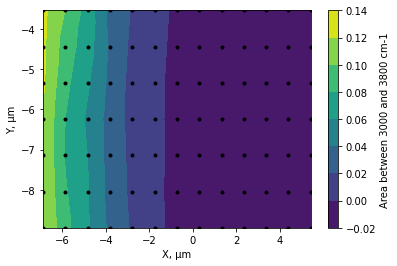

In [7]:
# select the region of interest
region_of_interest = np.array([[3000,3800]])
# use the area method to calculate the area A
my_map.area(my_map.I_normalised, region_of_interest)

# make a figure
plt.figure()
plt.tricontourf(my_map.X, my_map.Y, my_map.A)
plt.plot(my_map.X, my_map.Y, "k.") # this allows plotting the position of the measurements
plt.xlabel("X, µm")
plt.ylabel("Y, µm")
cbar = plt.colorbar()
cbar.set_label("Area between 3000 and 3800 cm-1")

D'après la figure ci-dessus, on remarque un gradient en X. En Y, aucun gradient n'est détecté. La bande à 3600 cm-1 correspondant à des vibrations d'étirement O-H, le gradient indique une différence de teneur en eau entre la bordure (X = -7) et le coeur du verre (X = 6).

Ci-dessous, nous pouvons manipuler les données pour récupérer une série de spectre à Y fixé. Pour cela nou définissons une petite fenêtre rectangulaire dans laquelle une seule ligne de donnée en Y est visible:

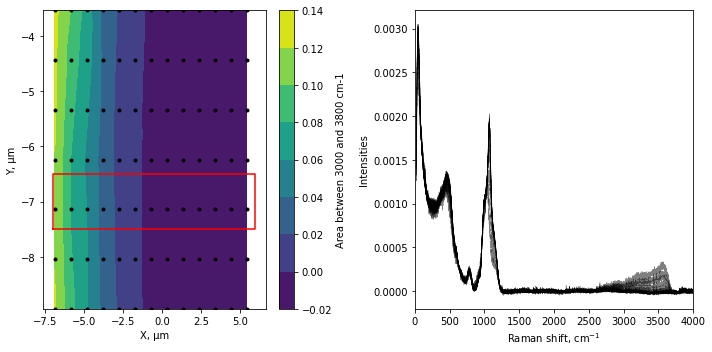

In [8]:
# Les coordonnées de la fenêtre (à modifier si nécessaire)
X_low = -7
X_high = 6
Y_low = -7.5
Y_high = -6.5

# On refait la figure ci-dessus avec le cadre, et 
# on montre aussi les spectres correspondant dans une deuxième sous-figure à droite

plt.figure(figsize=(10,5))

# sous figure 1 : notre carte d'aire avec le rectangle d'intérêt en rouge
plt.subplot(1,2,1)
plt.tricontourf(my_map.X, my_map.Y, my_map.A)
plt.plot([X_low, X_high, X_high, X_low, X_low], 
         [Y_low, Y_low, Y_high, Y_high, Y_low], "r-")
plt.plot(my_map.X, my_map.Y, "k.")

plt.xlabel("X, µm")
plt.ylabel("Y, µm")
cbar = plt.colorbar()
cbar.set_label("Area between 3000 and 3800 cm-1")

# sous figure 2 : les spectres dans le rectangle : à U fixe.
plt.subplot(1,2,2)

# on en profite ici pour récupérer les indices des spectres situés dans la zone délimitée par le rectangle
# ceci sera enregistré dans la variable idx_sp
# on peut donc ensuite l'utiliser pour représenter les spectres par exemple
idx_sp = np.where((my_map.X>X_low)&(my_map.X<X_high)&(my_map.Y>Y_low)&(my_map.Y<Y_high))
for i in idx_sp:
    plt.plot(my_map.w, my_map.I_normalised[:,i],"k-",alpha=0.5, linewidth=0.5)
    
plt.xlabel('Raman shift, cm$^{-1}$')
plt.ylabel("Intensities")

plt.xlim(0,4000)
    
plt.tight_layout()

## 4.2 traitement d'un profil de diffusion 1D

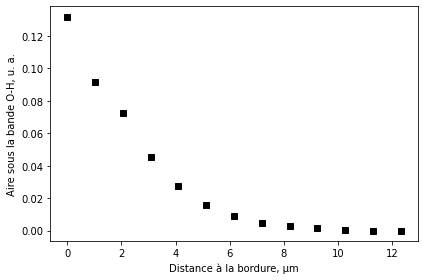

In [9]:
# Ci-dessous on utilise la variable idx_sp, créée ci-dessus, 
# pour récupérer la position en X des spectres, corrigée (la bordure à -7 (minimum) est remise à 0 par soustraction)
X_profile = my_map.X[idx_sp] - np.min(my_map.X[idx_sp])

# on récupère aussi les aires correspondantes
sp_profile = my_map.A[idx_sp] - np.min(my_map.A[idx_sp])

# on peut ainsi plotter le profil de diffusion
plt.figure()
plt.plot(X_profile, sp_profile, "ks")

plt.xlabel("Distance à la bordure, µm")
plt.ylabel("Aire sous la bande O-H, u. a.")
plt.tight_layout()

Le profil ci-dessus ressemble typiquement à un profil de diffusion. Nous voyons donc que de l'eau diffuse vers le coeur (anhydre) du verre. Nous pouvons donc utiliser une solution 1D de l'équation de diffusion de Fick dans un milieu semi-fini, avec une cocnentration C1 > C0.

Rampy offre une fonction simple pour ce calcul : rp.diffshort()

On la passe ici à une fonction anonyme car on a deux variables x en pratique : la distance et le temps. Or, curve_fit() ne marche qu'avec une variable X. Nous utilisons donc la fonction anonyme pour résoudre ce problème.

Le temps lors de cette expérience de diffusion était de 231 jours. Nous le rentrons ci-dessous en secondes.

### Ajustement avec une approche "statistique" moindre-carrée (fonction scipy.curve_fit())

The parameters for the 1D diffusion equations are:
C0 = 0.0006+/-0.0011 u.a., C1 = 0.129+/-0.002 u.a. et D = -18.56+/-0.03 m2 s-1


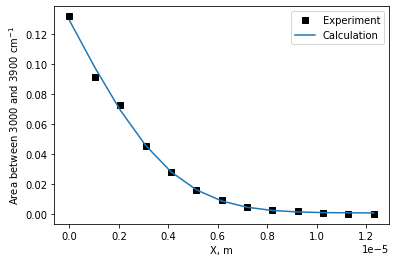

In [10]:
t = 231*24*3600 # time in seconds

# ici notre fonction anonyme pour le fit
# C0, C1 et D sont respectivement les concentrations au coeur et à la bordure du matériau, 
# et le log10 du coefficient de diffusion de l'espèce dans le matériau
Fick1D = lambda x, C0, C1, D: rp.diffshort(x,t,C0,C1,D)

# le fit est effectué ici en utilisant curve_fit(). Attention à donner des valeurs initiales dans la variable p0 réalistes !!
popt, pcov = curve_fit(Fick1D, X_profile*10**-6, sp_profile, p0=[-0.01, 0.05, -19])

# on fait une figure pour vérifier le fit.
plt.figure()
plt.plot(X_profile*10**-6, sp_profile, "ks", label = 'Experiment')
plt.plot(X_profile*10**-6, Fick1D(X_profile*10**-6,*popt), label = 'Calculation')

plt.xlabel('X, m')
plt.ylabel('Area between 3000 and 3900 cm$^{-1}$')

plt.legend()

# to print the results
diff_coefs = unumpy.uarray(popt, np.sqrt(np.diag(pcov)))
print('The parameters for the 1D diffusion equations are:')
print('C0 = {:0.4f} u.a., C1 = {:0.3f} u.a. et D = {:0.2f} m2 s-1'.format(*diff_coefs))



Ci-dessus, nous remarquons que les erreurs associées aux paramètres sont très petites... Est-ce réaliste ?

Pour répondre à cette question, nous pouvons réessayer de fitter les profils à chaque ligne de Y, et regarder la moyenne des paramètres ajustés:

In [11]:
# Les coordonnées de la fenêtre (à modifier si nécessaire)
X_low = -7
X_high = 6
# Ici des listes pour les valeurs inférieurs et supérieurs de Y
Y_low_list = [-9.5, -8.5, -7.5, -6.5, -6, -5, -4]
Y_high_list = [-8.5, -7.5, -6.5, -6, -5, -4, -3]

# une liste pour enregistrer les valeurs des paramètres
popt_Y = np.zeros((len(Y_low_list),3))

for i in range(len(Y_low_list)):

    # On attrape les bonnes valeurs en Y
    Y_low = Y_low_list[i]
    Y_high = Y_high_list[i]

    # On attrape le bon profil
    idx_sp = np.where((my_map.X>X_low)&(my_map.X<X_high)&(my_map.Y>Y_low)&(my_map.Y<Y_high))
    sp_profile_ = my_map.A[idx_sp] - np.min(my_map.A[idx_sp])
    
    # On le fit
    popt, pcov = curve_fit(Fick1D, X_profile*10**-6, sp_profile_, p0=[-0.01, 0.05, -19])
    
    # et on enregistre les résultats dans l'array
    popt_Y[i,:] = popt
    
# Nous pouvons ensuite imprimer les valeurs pour chaque paramètre
print("C0 = {:0.4f} +/- {:0.4f}".format(popt_Y[:,0].mean(),popt_Y[:,0].std()))
print("C1 = {:0.3f} +/- {:0.3f}".format(popt_Y[:,1].mean(),popt_Y[:,1].std()))
print("D = {:0.2f} +/- {:0.2f}".format(popt_Y[:,2].mean(),popt_Y[:,2].std()))

C0 = 0.0007 +/- 0.0003
C1 = 0.134 +/- 0.005
D = -18.55 +/- 0.02


Les valeurs trouvées précedemment semblent donc plutôt OK et bien contraintes.